<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/06_3_multi_cat_cats_dogs_revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cats and Dog model with Mult Cat**

With this, we can try to see whether it could discard any non dog or cat images.

## Setting Up on Colab

You only need to run this on Colab.

In [1]:
!pip install fastai2
!git clone https://github.com/arunoda/fastai-v4
%cd fastai-v4
!pwd

     |████████████████████████████████| 194kB 2.8MB/s 
Cloning into 'fastai-v4'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 117 (delta 45), reused 49 (delta 12), pack-reused 22
Receiving objects: 100% (117/117), 129.05 MiB | 37.69 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/fastai-v4
/content/fastai-v4


In [0]:
from fastai2.vision.all import *

## Load the Dataset

Loading the pets dataset

In [3]:
dataset = untar_data(URLs.PETS)

In [5]:
image_files = (dataset/"images").ls()
image_files

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_43.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_130.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_169.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_112.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_187.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_51.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_173.jpg')...]

In [6]:
dataset.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
def get_category(p):
  if p.name[0].isupper():
    return ['cat']
  else:
    return ['dog']

db = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_items = get_image_files,
    get_y = get_category,
    item_tfms = Resize(224),
    splitter = RandomSplitter(0.3)
)

In [0]:
dls = db.dataloaders(dataset/"images")

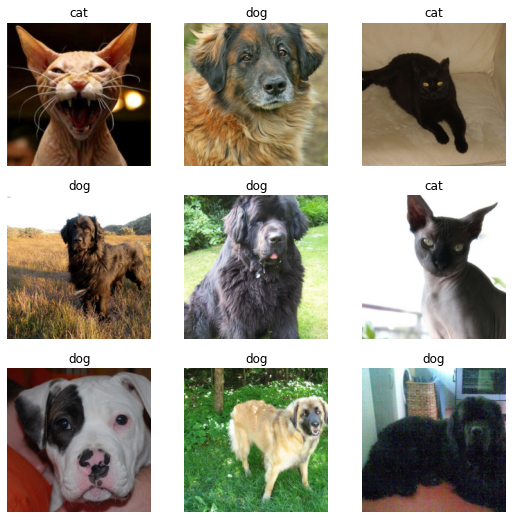

In [9]:
dls.show_batch()

## Creating the Model

In [0]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.9))

In [108]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.151594,0.023982,0.987145,00:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.046174,0.035106,0.984664,00:43
1,0.018603,0.008677,0.995264,00:43


## Making Predictions

In [0]:
from ipywidgets import widgets

In [0]:
uploader = widgets.FileUpload()

In [0]:
def predict(img, thresh):
  _, _, preds = learn.predict(img)
  res = preds > thresh
  return learn.dls.vocab[res], preds

In [0]:
def predictUploaded(thresh):
  uploaded_img = PILImage.create(uploader.data[-1])
  show_image(uploaded_img)
  return predict(uploaded_img, thresh)

In [111]:
uploader

FileUpload(value={'Screenshot 2020-05-16 at 23.18.04.png': {'metadata': {'lastModified': 1589651287695, 'type'…

((#1) ['cat'], tensor([1.0000e+00, 1.8029e-07]))

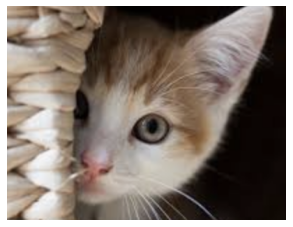

In [112]:
predictUploaded(0.9)